# Notebook examples for Chapter 7

In [5]:
import ee
#ee.Authenticate()
ee.Initialize()
%matplotlib inline

## 7.1 Postprocessing

### 7.1.2. Probabilistic label relaxation

In [ ]:
%run scripts/classify -a 6 -p [1,2,3,4,5] -L [10,10] -e 100 -P imagery/AST_20070501_pca.tif imagery/train.shp

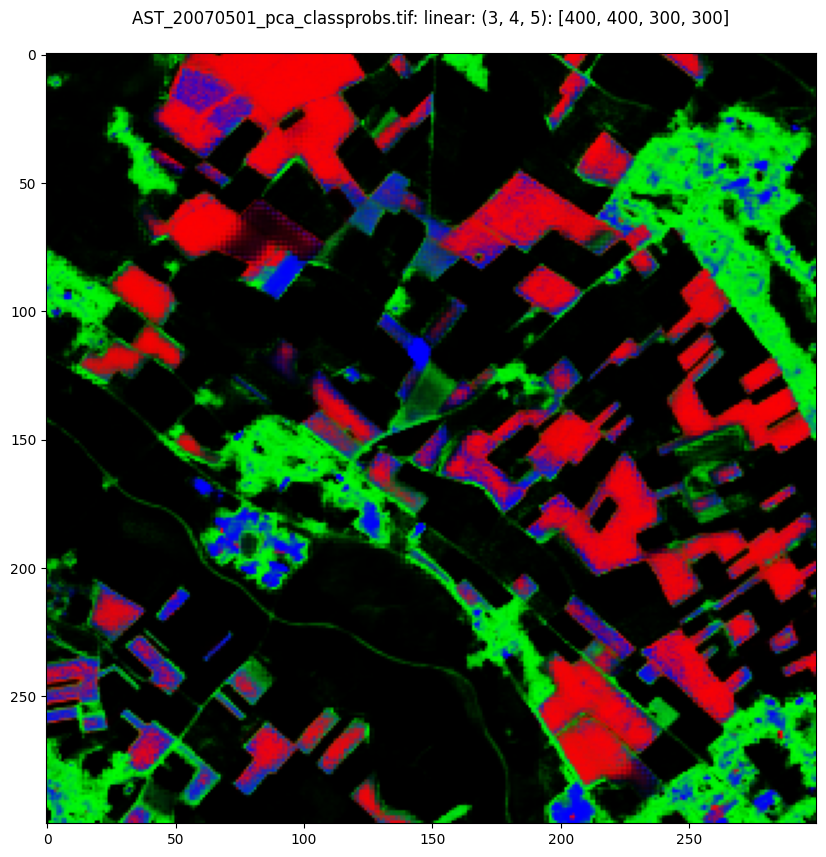

<Figure size 640x480 with 0 Axes>

In [8]:
%run scripts/dispms -f imagery/AST_20070501_pca_classprobs.tif -e 2 -p [3,4,5] -d [400,400,300,300]

In [9]:
run scripts/plr -i 3 imagery/AST_20070501_pca_classprobs.tif

       PLR
infile:  imagery/AST_20070501_pca_classprobs.tif
iterations:  3
estimating compatibility matrix...
label relaxation...
iteration 1
iteration 2
iteration 3
result written to: imagery/AST_20070501_pca_classprobs_plr.tif
elapsed time: 48.661951780319214
--done------------------------


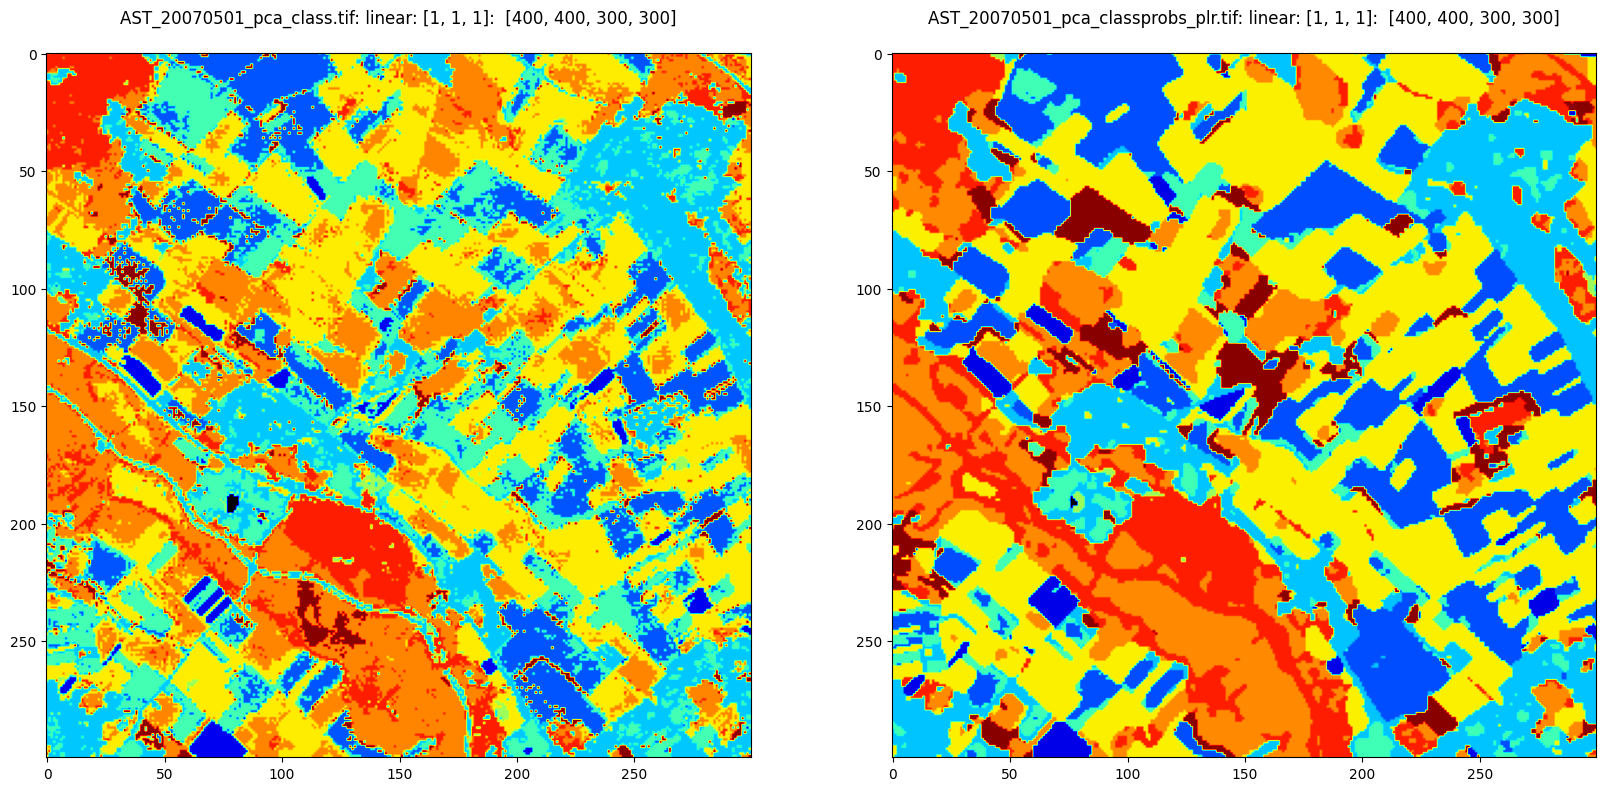

<Figure size 640x480 with 0 Axes>

In [10]:
%run scripts/dispms -f imagery/AST_20070501_pca_class.tif -c -d [400,400,300,300] \
-F imagery/AST_20070501_pca_classprobs_plr.tif -C -D [400,400,300,300] \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter7/fig7_1.eps'

## 7.2 Evaluation and comparison of classification accuracy

### 7.2.1 Accuracy assessment

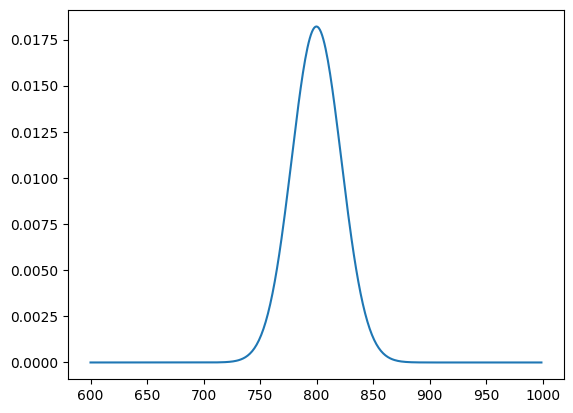

In [4]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

theta = 0.4
n = 2000
x = np.arange(600, 1000)
# pmf = probability mass function
plt.plot(x, binom.pmf(x, n, theta))

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter7/fig7_2.eps')

In [5]:
run scripts/ct imagery/AST_20070501_pca_NNet(Congrad).tst

classification statistics
NNet(Congrad)test results for imagery/AST_20070501_pca.tif 
Mon Jun  3 09:25:28 2024
Classification image: imagery/AST_20070501_pca_class.tif 
Class probabilities image: imagery/AST_20070501_pca_classprobs.tif 

Misclassification rate: 0.067682
Standard deviation: 0.005166
Conf. interval (95 percent): [0.058241 , 0.078526]
Kappa coefficient: 0.923651
Standard deviation: 0.005825
Contingency Table
[[ 197.       0.       0.       0.       0.       0.       0.       0.       0.       0.     197.       1.   ]
 [   0.     166.       0.       0.       1.       0.       2.       0.       0.       0.     169.       0.982]
 [   0.       0.     252.       0.       2.       0.       0.       0.       0.       1.     255.       0.988]
 [   0.       0.       0.     288.      17.       1.       0.       1.       0.       0.     307.       0.938]
 [   0.       0.       2.       7.     224.       0.       0.       0.       0.       0.     233.       0.961]
 [   0.       0.   

<Figure size 640x480 with 0 Axes>

### 7.2.2 Accuracy assessment on the GEE

In [6]:
import ee
ee.Initialize()
# first 4 principal components of ASTER image
image = ee.Image('projects/ee-mortcanty/assets/CRC5/AST_20070501_pca') \
                                      .select(0,1,2,3)
# training data
table = ee.FeatureCollection('projects/ee-mortcanty/assets/CRC5/train')
# sample the image with the polygons to a feature  
# collection, rename the class id columns from strings 
# to integers, add a column of random numbers in [0,1]
trainTestData = image.sampleRegions(collection=table,
                                properties=['CLASS_ID'],
                                scale=15) \
 .remap(list(map(str,range(10))),list(range(10)),
                                           'CLASS_ID') \
 .randomColumn('rand',seed=12345) 
# filter on the random column to split into training and
# test feature collections in the ration of 2:1
trainData = trainTestData.filter(ee.Filter.lt('rand',0.67))
testData = trainTestData.filter(ee.Filter.gte('rand',0.67))
print('train pixels: %i'%trainData.size().getInfo())
print('test pixels:  %i'%testData.size().getInfo())
# train a (default) SVM classifier on training data   
classifier = ee.Classifier.libsvm()
trained = classifier.train(trainData,'CLASS_ID',
                                   image.bandNames()) 
# test the trained classifier with the test data
tested = testData.classify(trained)
# generate a confusion matrix with the 
# classified test data
cm = tested.errorMatrix('CLASS_ID','classification')
# and from it determine the accuracy and kappa 
print('accuracy: %f'%cm.accuracy().getInfo())
print('kappa:    %f'%cm.kappa().getInfo())

train pixels: 4801
test pixels:  2372
accuracy: 0.946880
kappa:    0.939896


### 7.2.3 Crossvalidation on parallel architectures

In [16]:
run scripts/crossvalidate -p [1,2,3,4,5] -a 6 -e 10 -L [10,10] -e 1000 imagery/AST_20070501_pca.tif imagery/train.shp

10-fold cross validation, algorithm: Dnn(Tensorflow)
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


7162 training pixel vectors were read in
attempting parallel calculation ...
available engines [0, 1, 2, 3, 4, 5, 6, 7]
execution time: 881.4019334316254
misclassification rate: 0.031556
standard deviation:     0.006962


### 7.2.4 Model comparison

In [7]:
run scripts/classify -p [1,2,3,4,5] -a 6 -L [10,10] -e 500 imagery/AST_20070501_pca.tif imagery/train.shp

Training with Dnn(tensorflow)
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 85.960440158844
classifying...
row: 0
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 493us/step
row: 100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 501us/step
row: 200
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 493us/step
row: 300
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 495us/step
row: 400
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 506us/step
row: 500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 499us/step
row: 600
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 538us/step
row: 700
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 501us/step
row: 800
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 514us/step
row: 900
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 493us/step
elapsed time 16.01184105873108
thematic map written to: imagery/AST_20070501_pca_class.tif
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
test results written to: imagery/AST_20070501_pca_Dnn(tensorflow).tst
done


In [8]:
run scripts/classify -p [1,2,3,4,5] -a 7 imagery/AST_20070501_pca.tif imagery/train.shp

Training with SVM
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 0.23722481727600098
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 68.42088389396667
thematic map written to: imagery/AST_20070501_pca_class.tif
test results written to: imagery/AST_20070501_pca_SVM.tst
done


In [9]:
%run scripts/mcnemar imagery/AST_20070501_pca_SVM.tst \
imagery/AST_20070501_pca_Dnn(tensorflow).tst 

     McNemar test
first classifier:
SVMtest results for imagery/AST_20070501_pca.tif 
Mon Jun  3 11:00:04 2024
Classification image: imagery/AST_20070501_pca_class.tif 
Class probabilities image: None 

second classifier:
Dnn(tensorflow)test results for imagery/AST_20070501_pca.tif 
Mon Jun  3 10:58:34 2024
Classification image: imagery/AST_20070501_pca_class.tif 
Class probabilities image: None 

test observations: 2364
classes: 10
first classifier: 96
second classifier: 84
McNemar statistic: 0.800000
P-value: 0.371093


In [10]:
run scripts/classify -p [1,2,3,4,5] -a 2  imagery/AST_20070501_pca.tif imagery/train.shp

Training with Gausskernel
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']


/home/mort/python/CRC5Docker/src/auxil/supervisedclass.py:98: RuntimeWarning: invalid value encountered in divide
  return pvs/s


sigma: 0.001000  error: 0.355356
sigma: 0.100000  error: 0.047520
sigma: 1.000000  error: 0.194873
sigma: 0.443769  error: 0.132138
sigma: 0.231308  error: 0.096499
sigma: 0.150155  error: 0.070029
sigma: 0.062185  error: 0.035015
sigma: 0.038815  error: 0.028554
sigma: 0.024371  error: 0.026886
sigma: 0.018038  error: 0.027720
sigma: 0.026739  error: 0.027511
sigma: 0.022652  error: 0.026886
sigma: 0.023511  error: 0.026678
sigma: 0.023535  error: 0.026678
sigma: 0.023558  error: 0.026678
sigma: 0.023869  error: 0.026678
sigma: 0.024060  error: 0.026886
sigma: 0.023750  error: 0.026678
sigma: 0.023677  error: 0.026678
sigma: 0.023632  error: 0.026678
sigma: 0.023604  error: 0.026678
elapsed time 25.674996852874756
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 347.87821650505066
thematic map written to: imagery/AST_20070501_pca_class.tif
test results written to: imagery/AST_20070501_pca_Gausskernel.tst
done


In [11]:
%run scripts/mcnemar imagery/AST_20070501_pca_Gausskernel.tst \
imagery/AST_20070501_pca_Dnn(tensorflow).tst

     McNemar test
first classifier:
Gausskerneltest results for imagery/AST_20070501_pca.tif 
Mon Jun  3 11:06:59 2024
Classification image: imagery/AST_20070501_pca_class.tif 
Class probabilities image: None 

second classifier:
Dnn(tensorflow)test results for imagery/AST_20070501_pca.tif 
Mon Jun  3 10:58:34 2024
Classification image: imagery/AST_20070501_pca_class.tif 
Class probabilities image: None 

test observations: 2364
classes: 10
first classifier: 54
second classifier: 91
McNemar statistic: 9.441379
P-value: 0.002121


### 7.3.1 Adaptive boosting

Training with ADABOOST.M1 and 5 epochs per ffn
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


running instance: 1  trial: 1
train error: 0.037932 test error: 0.037225
running instance: 2  trial: 1
train error: 0.033347 test error: 0.034687
running instance: 3  trial: 1
train error: 0.033139 test error: 0.034687
running instance: 4  trial: 1
train error: 0.032097 test error: 0.032995
running instance: 5  trial: 1
train error: 0.032722 test error: 0.033841
running instance: 6  trial: 1
train error: 0.032097 test error: 0.031726
running instance: 7  trial: 1
train error: 0.031888 test error: 0.031726
running instance: 8  trial: 1
train error: 0.031263 test error: 0.030880
running instance: 9  trial: 1
train error: 0.031263 test error: 0.030880
running instance: 10  trial: 1
train error: 0.031263 test error: 0.030880
running instance: 11  trial: 1
train error: 0.030638 test error: 0.030880
running instance: 12  trial: 1
train error: 0.031055 test error: 0.030880
running instance: 13  trial: 1
train error: 0.030638 test error: 0.030880
running instance: 14  trial: 1
train error: 0.0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


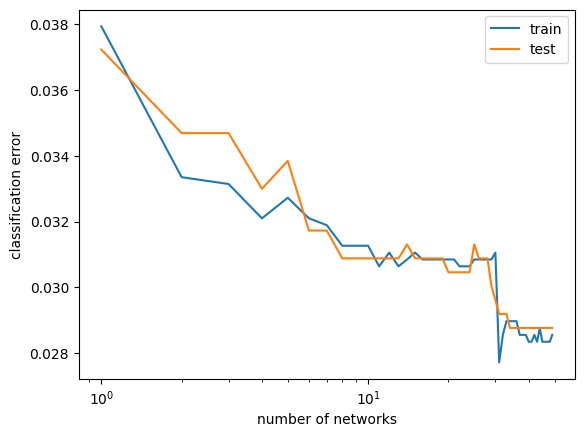

classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
thematic map written to: imagery/AST_20070501_pca_class.tif
elapsed time 16.63132905960083


<Figure size 640x480 with 0 Axes>

In [12]:
run scripts/adaboost -p [1,2,3,4,5]  -L 10 -n 50 imagery/AST_20070501_pca.tif  imagery/train.shp

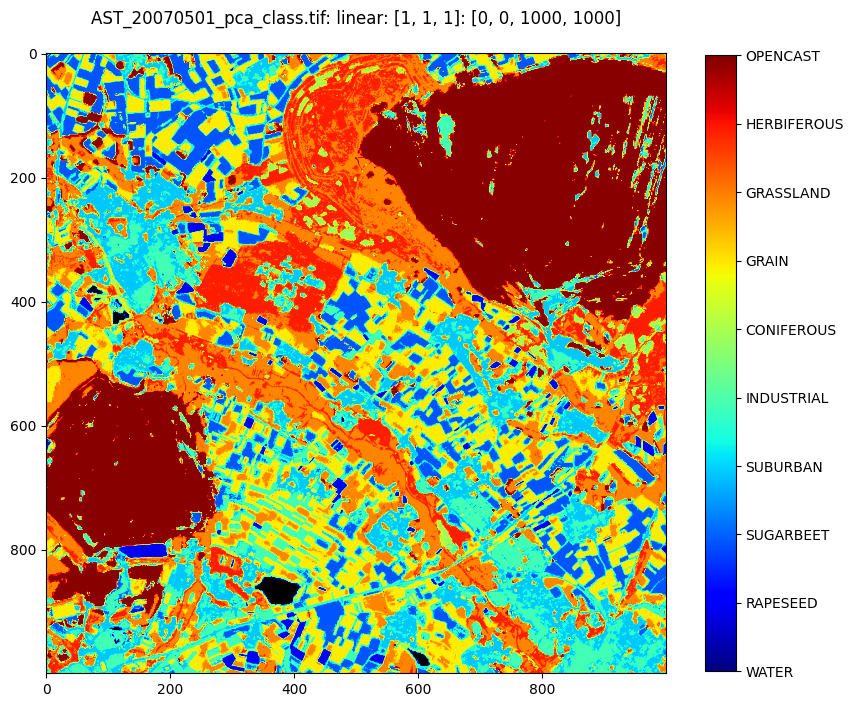

<Figure size 640x480 with 0 Axes>

In [13]:
%run scripts/dispms -f /home/mort/python/CRC5Docker/src/imagery/AST_20070501_pca_class.tif -c \
-r  "['WATER', 'RAPESEED', 'SUGARBEET', 'SUBURBAN', 'INDUSTRIAL', 'CONIFEROUS', 'GRAIN', 'GRASSLAND', 'HERBIFEROUS', 'OPENCAST']" \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter7/fig7_x.eps'

### 7.3.2 Random forests

In [2]:
run scripts/classify -p [1,2,3,4,5] -a 8  imagery/AST_20070501_pca.tif imagery/train.shp

2024-06-03 20:03:44.499225: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-03 20:03:44.501406: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-03 20:03:44.589064: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-03 20:03:44.945107: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 20:03:45.744104: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

Training with RF
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 1.915858268737793
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 20.92259645462036
thematic map written to: imagery/AST_20070501_pca_class.tif
test results written to: imagery/AST_20070501_pca_RF.tst
done


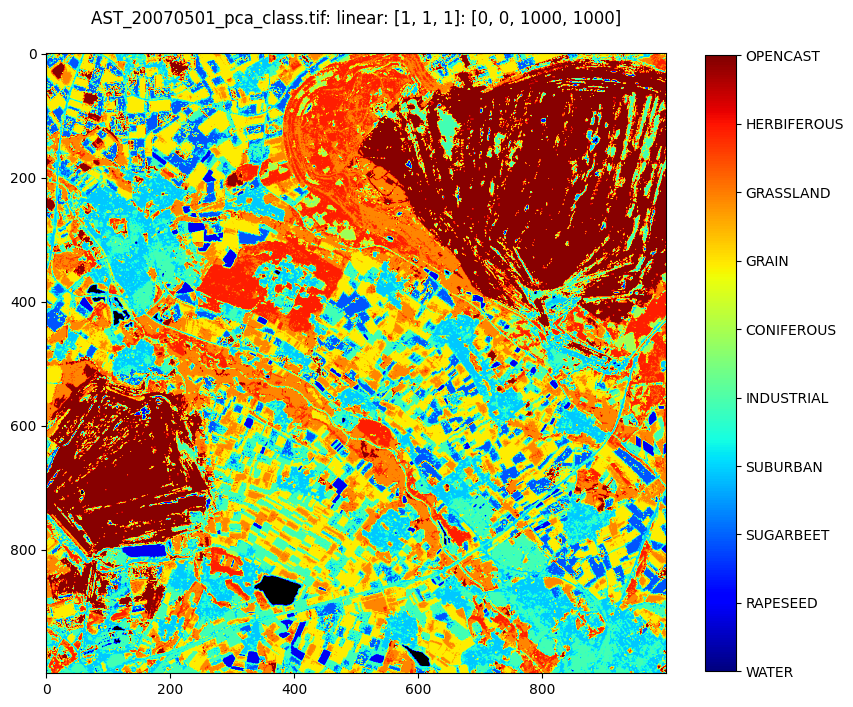

<Figure size 640x480 with 0 Axes>

In [3]:
%run scripts/dispms -f /home/mort/python/CRC5Docker/src/imagery/AST_20070501_pca_class.tif -c \
-r  "['WATER', 'RAPESEED', 'SUGARBEET', 'SUBURBAN', 'INDUSTRIAL', 'CONIFEROUS', 'GRAIN', 'GRASSLAND', 'HERBIFEROUS', 'OPENCAST']"

In [4]:
%run scripts/mcnemar imagery/AST_20070501_pca_Gausskernel.tst \
imagery/AST_20070501_pca_RF.tst

     McNemar test
first classifier:
Gausskerneltest results for imagery/AST_20070501_pca.tif 
Mon Jun  3 11:06:59 2024
Classification image: imagery/AST_20070501_pca_class.tif 
Class probabilities image: None 

second classifier:
RFtest results for imagery/AST_20070501_pca.tif 
Mon Jun  3 20:04:12 2024
Classification image: imagery/AST_20070501_pca_class.tif 
Class probabilities image: None 

test observations: 2364
classes: 10
first classifier: 54
second classifier: 75
McNemar statistic: 3.418605
P-value: 0.064465


## 7.5 Hyperspectral image analysis

In [4]:
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly
import numpy as np
import matplotlib.pyplot as plt

inDataset = gdal.Open('imagery/97_radianz_registriert_voll',GA_ReadOnly)                       
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize    
bands = inDataset.RasterCount
print(rows, cols, bands)

512 614 224


ERROR 1: Maximum number of characters allowed reached.


In [5]:
Im = np.zeros((rows,cols,bands)) 
for b in range(bands):
    band = inDataset.GetRasterBand(b+1)
    Im[:,:,b] = band.ReadAsArray(0,0,cols,rows)  

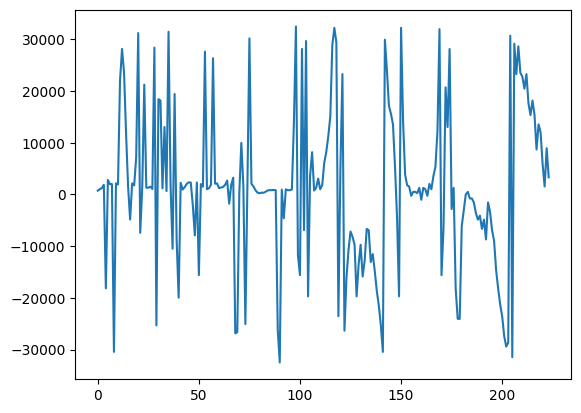

In [6]:
# spectral cut
plt.plot(Im[300,300,:])
#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter7/fig7_6.eps',bbox_inches='tight')

### 7.5.3 Intrinsic end-members and pixel purity

------------MNF ---------------
Mon May  6 13:25:54 2024
Input imagery/97_radianz_registriert_voll


ERROR 1: Maximum number of characters allowed reached.


Signal to noise ratios: [8.176397   5.2275453  4.3195086  2.9181838  2.5331788  2.2690113
 2.195611   2.0360427  1.7489603  1.7093334  1.6091063  1.5357301
 1.3793161  1.2976725  1.2197104  1.1656473  1.109391   1.0812812
 1.0492995  1.0363803  0.9592868  0.8728442  0.84626555 0.83644605
 0.80188596 0.7913779  0.75585747 0.74410915 0.73713434 0.69875026
 0.68781054 0.6800947  0.6698389  0.64265275 0.63974833 0.63259935
 0.62931275 0.6187433  0.6155267  0.6120652  0.6062727  0.5949068
 0.5930885  0.5872364  0.58242977 0.5785725  0.575614   0.57014716
 0.569322   0.5627202  0.55612826 0.5542084  0.5493144  0.54553616
 0.5439917  0.5419792  0.54117393 0.5379422  0.5349852  0.52995193
 0.5218158  0.519151   0.51607347 0.51372373 0.5118644  0.50964975
 0.50605047 0.5009295  0.4989127  0.49580038 0.49361134 0.4916891
 0.49010277 0.4873197  0.4858873  0.48411143 0.48317504 0.4807427
 0.47730327 0.4760946  0.4709202  0.46978903 0.46692216 0.46574378
 0.46271026 0.45855892 0.4543023  0.45317924

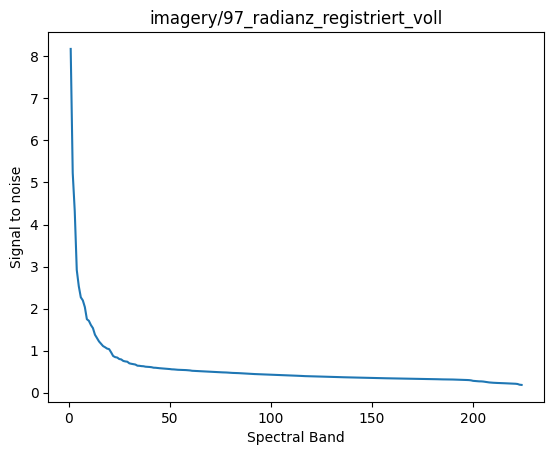

MNFs written to: imagery/97_radianz_registriert_voll_mnf
elapsed time: 7.119639158248901


<Figure size 640x480 with 0 Axes>

In [7]:
run scripts/mnf.py imagery/97_radianz_registriert_voll

### 7.5.4 Anomaly detection: The RX algorithm

In [8]:
run scripts/rx imagery/AST_20070501_pca.tif


------------ RX ---------------
Mon May  6 13:26:17 2024
Input imagery/AST_20070501_pca.tif


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Result written to imagery/AST_20070501_pca_rx.tif
elapsed time: 0.33540821075439453


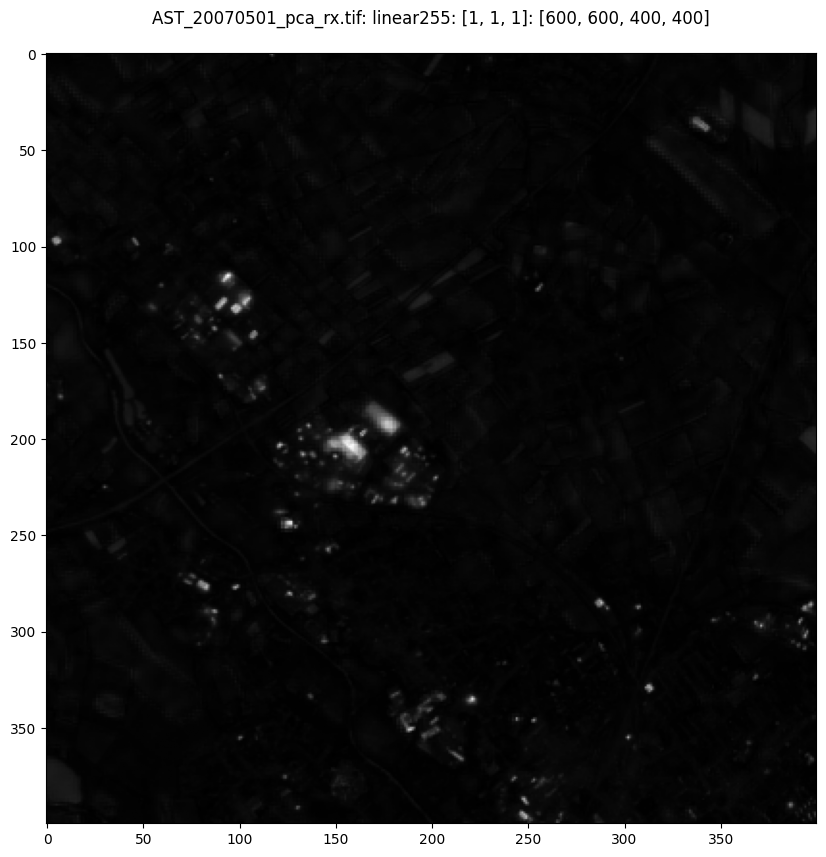

<Figure size 640x480 with 0 Axes>

In [9]:
run scripts/dispms -f imagery/AST_20070501_pca_rx.tif -e 1 -d [600,600,400,400]

### 7.5.5 Anomaly detection: The kernel RX algorithm

In [10]:
run scripts/krx -s 2000 imagery/AST_20070501_pca.tif

Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


------------ KRX ---------------
Mon Apr 29 13:19:34 2024
Input imagery/AST_20070501_pca.tif
GMA: 0.000000
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
Result written to imagery/AST_20070501_pca_krx.tif
elapsed time: 89.86909246444702


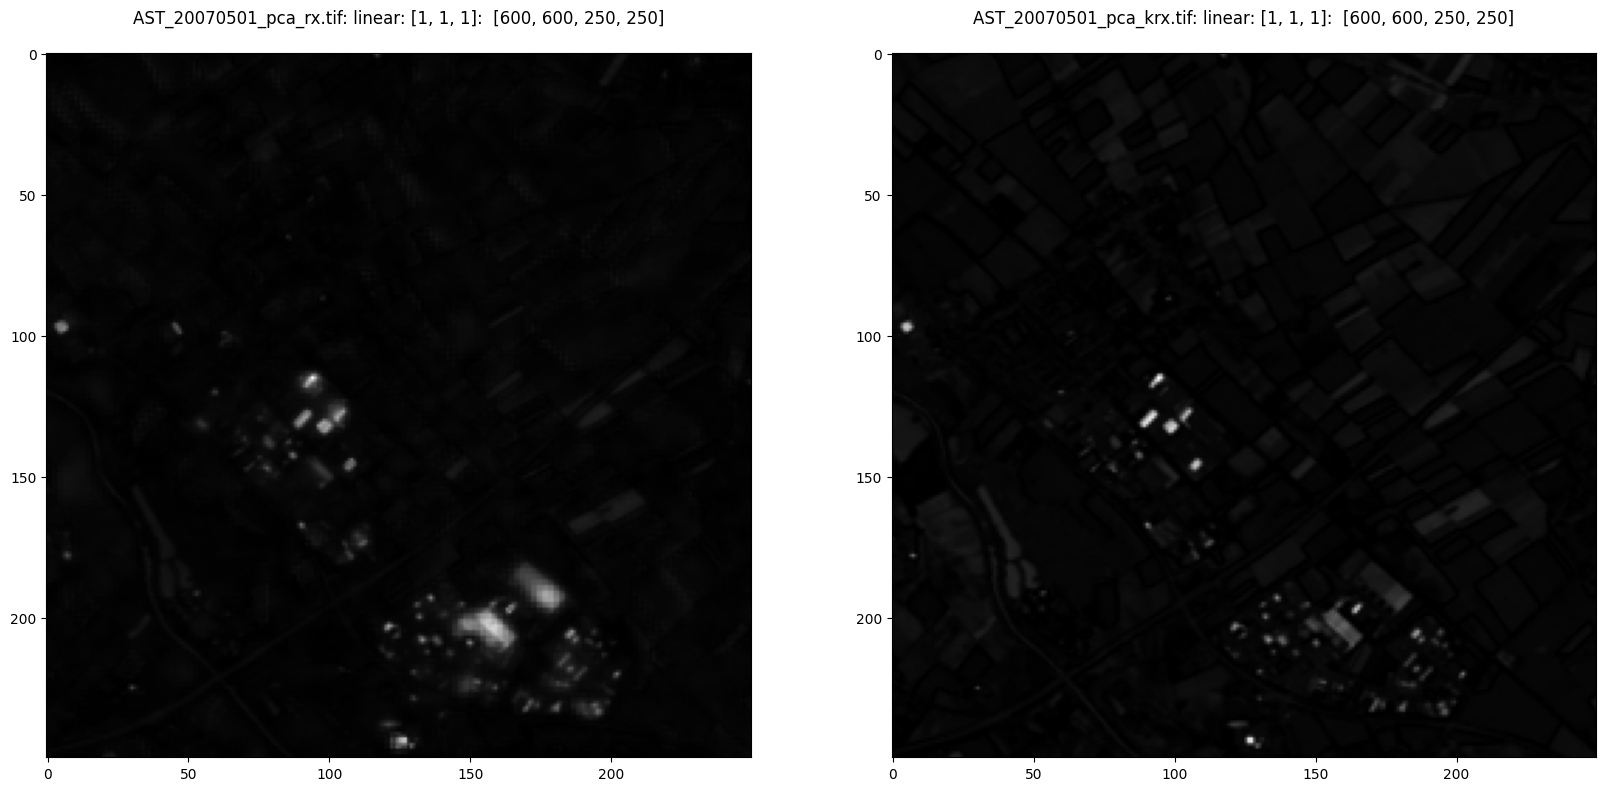

In [16]:
%run scripts/dispms -f imagery/AST_20070501_pca_rx.tif -e 2 -d [600,600,250,250] \
-F imagery/AST_20070501_pca_krx.tif -E 2 -D [600,600,250,250] \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter7/fig7_9.eps'

## 7.6 Convolutional neural networks

### 7.6.1 Transfer learning

The examples in the text can be run on Google Colab with a GPU runtime. Use this link:

https://colab.research.google.com/drive/1aleipk9k16e5jAjR1FqcOl9NB7FUjLng

### 7.6.2 Semantic segmentation with U-net architecture

These examples should be run on Google Colab with a GPU runtime. Use this link:

https://colab.research.google.com/drive/1l8fkUqjQ2trzcTqViis_RWoDesidFv_9